In [35]:
#import all the essential libraries

import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords 

In [2]:
# To find out the name of the input file
import os


In [3]:
#import the csv as df
df= pd.read_csv('/kaggle/input/movie-review/movie_review.csv')


In [4]:
df.head()

,fold_id,cv_tag,html_id,sent_id,text,tag
0,0,cv000,29590,0,films adapted from comic books have had plenty...,pos
1,0,cv000,29590,1,"for starters , it was created by alan moore ( ...",pos
2,0,cv000,29590,2,to say moore and campbell thoroughly researche...,pos
3,0,cv000,29590,3,"the book ( or "" graphic novel , "" if you will ...",pos
4,0,cv000,29590,4,"in other words , don't dismiss this film becau...",pos


In [5]:
#replace pos and neg as '1' and 'o'
df.tag[df.tag == 'pos'] = 1
df.tag[df.tag == 'neg'] = 0

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
# shuffle the df well and check for the tag column changes
from sklearn.utils import shuffle
df = shuffle(df)
df.head() 

,fold_id,cv_tag,html_id,sent_id,text,tag
15111,4,cv472,29280,9,of course jay's interpretation immediately get...,1
57375,7,cv764,12701,11,"filled with wealthy african-americans , the st...",0
509,0,cv018,20137,7,"maroon thinks that roger's wife , jessica's , ...",1
14880,4,cv466,18722,8,""" no father , i didn't , "" ronnie answers .",1
58595,8,cv805,21128,22,everyone seems enthusiastic about being there ...,0


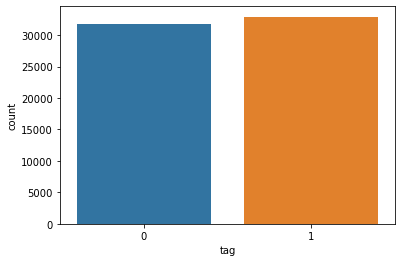

In [7]:
import seaborn as sns
sns.countplot(x='tag',data=df)

In [8]:
df.tag

15111    1
57375    0
509      1
14880    1
58595    0
        ..
12196    1
31278    1
60707    0
25811    1
6166     1
Name: tag, Length: 64720, dtype: object

In [9]:
#set tag as target
target = df['tag'].values
target = np.array(target, dtype='int64')

* Create a function 'clean_word' that replaces punctuation with blank spaces, and appends only numbers and alphabets to 'new', excluding stopwords, and perform steeming and append the words to'new'..

In [10]:
# we use lemmatization techniques to reduce the number of words in the vocabulary
STOPWORDS = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer
  
lemmatizer = WordNetLemmatizer() 

def clean_word(word_list):
    global STOPWORDS
    new = []
    for word in word_list:
        word = word.replace('.', '')
        word = word.replace(',', '')
        word = word.replace(';', '')
        word = word.lower()
        if (word.isalpha() or word.isdigit()) and word not in STOPWORDS:   
            new.append(lemmatizer.lemmatize(word))
    return new

In [11]:
from sklearn.preprocessing import LabelEncoder

text = df['text'].values

# Tokenize each sentence 
text_arr = [row.split(' ') for row in text]

In [12]:
vocab = []
clean_text_array = []
for row in text_arr:
    clean_row = clean_word(row)
    clean_text_array.append(clean_row)
    vocab.extend(clean_row)

In [13]:
#set and list all the words to vocabulary and print the length(to get a count of the number of words)
vocabulary = list(set(vocab))
len(vocabulary)

33617

In [14]:

vectorizer = LabelEncoder()
vectorizer.fit(vocabulary)

# Create token vector using Label Encoder fit on entire vocabulary
token_vector = []
# declare max_words to keep count of the longest sentence vectorized
# we need this to pad every other vector to same length as longest vector

max_words = 0 
for row in clean_text_array:
    encoded = vectorizer.transform(row).tolist()
    size = len(encoded)
    if size>max_words: 
        max_words=size
    token_vector.append(encoded)

In [15]:
max_words #print max_words

74

In [16]:
# pad each sentence with zeros to the length of the longest sentence
padded = []
for row in token_vector:
    r = np.pad(row, (0, max_words-len(row)), 'constant')
    padded.append(r)

In [17]:
# all padded sentences to example vector

ex_vector = np.array(padded)

In [18]:
# split train and test data into 80:20, data=ex_vector, target=tag

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(ex_vector,target, test_size=0.2)

In [19]:
import tensorflow as tf

split the data into batches and shuffle

In [20]:
train_dataset = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
test_dataset = tf.data.Dataset.from_tensor_slices((xtest, ytest))

In [21]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [22]:
type(train_dataset)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [23]:
from tensorflow import keras  

In [24]:
embedding_dim=16 

# defining the sequential model with an Embedding layer
# Add a Global Average Pooling 1D layer to flattent the matrix into vector

model = keras.models.Sequential([
  keras.layers.Embedding(33617, embedding_dim), #130590 as input based on vocabulary
  keras.layers.GlobalAveragePooling1D(),
  keras.layers.Dense(32, activation='relu'),
  keras.layers.Dense(1, activation='sigmoid')
])

In [25]:
#complie the model
model.compile(optimizer=keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [26]:
epochs=5                  #five iterations
history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset, verbose=2)

Train for 809 steps, validate for 203 steps
Epoch 1/5
809/809 - 5s - loss: 0.6812 - accuracy: 0.5639 - val_loss: 0.6428 - val_accuracy: 0.6561
Epoch 2/5
809/809 - 4s - loss: 0.5747 - accuracy: 0.7007 - val_loss: 0.5916 - val_accuracy: 0.6843
Epoch 3/5
809/809 - 4s - loss: 0.4973 - accuracy: 0.7524 - val_loss: 0.5951 - val_accuracy: 0.6891
Epoch 4/5
809/809 - 4s - loss: 0.4494 - accuracy: 0.7838 - val_loss: 0.6097 - val_accuracy: 0.6915
Epoch 5/5
809/809 - 4s - loss: 0.4167 - accuracy: 0.8037 - val_loss: 0.6312 - val_accuracy: 0.6889


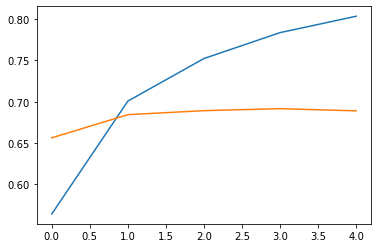

In [29]:
# Plot Accuracy
plt.plot(range(epochs), history.history['accuracy'])
plt.plot(range(epochs), history.history['val_accuracy'])


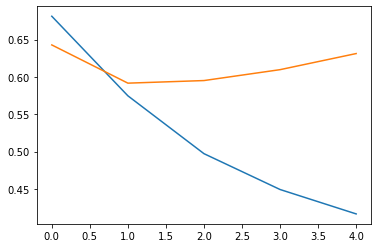

In [30]:
# Plot Loss
plt.plot(range(epochs), history.history['loss'])
plt.plot(range(epochs), history.history['val_loss'])

In [33]:
pred = model.predict_classes(xtest)

In [37]:
cm = confusion_matrix(ytest,pred)
cm

array([[4641, 1690],
       [2337, 4276]])

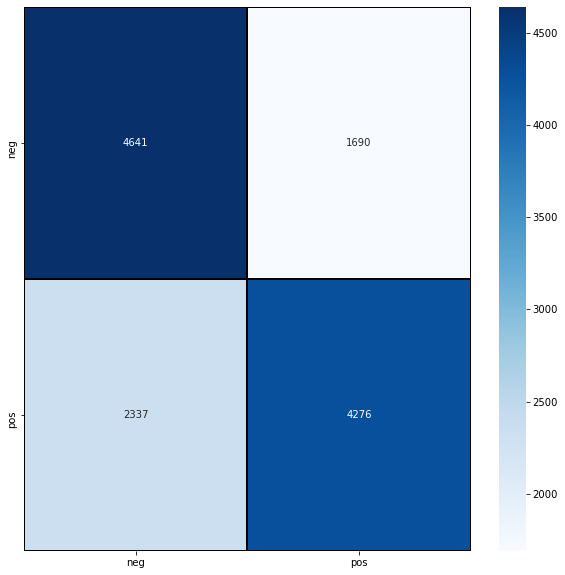

In [38]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['neg','pos'] , yticklabels = ['neg','pos'])

SEE THE READ ME FILE FOR INTRODUCTION,PROCEDURE AND CONCLUSION